**"Hands on ... " Chapter 7 – Ensemble Learning and Random Forests**

##### 01/27/21
#### Continuation on FHWA pile data
- regression for Qu
- ANN for Load-Settlement

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/07_ensemble_learning_and_random_forests.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Setup

In [1]:
from preamble import *
%matplotlib inline

In [2]:
import os
import sys
print("Python 버전:", sys.version)

import pandas as pd
print("pandas 버전:", pd.__version__)

import numpy as np
print("NumPy 버전:", np.__version__)

import scipy as sp
print("SciPy 버전:", sp.__version__)

import IPython
print("IPython 버전:", IPython.__version__)

import sklearn
print("scikit-learn 버전:", sklearn.__version__)

Python 버전: 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
pandas 버전: 1.1.5
NumPy 버전: 1.16.6
SciPy 버전: 1.5.0
IPython 버전: 7.18.1
scikit-learn 버전: 0.22


In [3]:
# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Get the data

In [4]:
import os

data = pd.read_csv(os.path.join(mglearn.datasets.DATA_PATH, "FHWA.csv"))
#display(data.head())


In [5]:
print(data.keys())
print(data.shape)

Index(['Project', 'Name', 'Pile', 'MaxF', 'MaxD', 'Len', 'Dia', 'Qu', 'Ns1',
       'Ns2', 'Ns3', 'Ns4', 'Ns5', 'NB', 'Sand', 'Clay', 'Silt', 'qc1', 'qc2',
       'qc3', 'qc4', 'qc5', 'qct', 'qs1', 'qs2', 'qs3', 'qs4', 'qs5', 'qst'],
      dtype='object')
(54, 29)


---
#### Prepare the data for ML algorithm
* *Data Cleaning*
* *Handling Text and Categorical Attributes*
* *Custom Transformers*
* *Feature Scaling*
* *Transformation Pipelines*

---

#### *Handling NaN etc.*

In [6]:
#Select missing values, show two rows
#df[df['qct'].isnull()].head(5)
# Load data, set missing values
df = pd.read_csv(os.path.join(mglearn.datasets.DATA_PATH, "FHWA.csv"),
                na_values=[np.nan, 'None', -999])
# to make blank to blank instead of NaN
#                keep_default_na=False, na_values=[np.nan, 'NONE', -999])
#display(df.iloc[0:1,25:])
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 29 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Project  54 non-null     int64  
 1   Name     54 non-null     object 
 2   Pile     54 non-null     object 
 3   MaxF     54 non-null     float64
 4   MaxD     54 non-null     float64
 5   Len      54 non-null     float64
 6   Dia      54 non-null     float64
 7   Qu       54 non-null     int64  
 8   Ns1      54 non-null     float64
 9   Ns2      54 non-null     float64
 10  Ns3      54 non-null     float64
 11  Ns4      54 non-null     float64
 12  Ns5      54 non-null     float64
 13  NB       54 non-null     float64
 14  Sand     54 non-null     int64  
 15  Clay     54 non-null     int64  
 16  Silt     54 non-null     int64  
 17  qc1      14 non-null     float64
 18  qc2      14 non-null     float64
 19  qc3      14 non-null     float64
 20  qc4      14 non-null     float64
 21  qc5      14 non-nu

Project     0
Name        0
Pile        0
MaxF        0
MaxD        0
Len         0
Dia         0
Qu          0
Ns1         0
Ns2         0
Ns3         0
Ns4         0
Ns5         0
NB          0
Sand        0
Clay        0
Silt        0
qc1        40
qc2        40
qc3        40
qc4        40
qc5        40
qct        40
qs1        40
qs2        40
qs3        40
qs4        40
qs5        40
qst        40
dtype: int64

#### *Add average N and Cone Resistacne*

In [7]:
df['mean_N'] = df.iloc[:, 8:13].mean(axis=1)
df['mean_qc'] = df.iloc[:, 17:22].mean(axis=1)
df['mean_qs'] = df.iloc[:, 23:28].mean(axis=1)

### *Looking for corrlations*

In [8]:
# 몇개의 열만 선택합니다
df = df[['MaxF', 'MaxD','Qu', 'Len', 'Dia', 'mean_N', 'NB','mean_qc','qct','mean_qs','qst']]
# IPython.display 함수는 주피터 노트북을 위해 포맷팅된 출력을 만듭니다
display(df.head())
df.info()

,MaxF,MaxD,Qu,Len,...,mean_qc,qct,mean_qs,qst
0,3407.3,-44.0,2700,36.6,...,NaN,NaN,NaN,NaN
1,818.5,-27.7,800,12.2,...,NaN,NaN,NaN,NaN
2,1331.8,-23.7,1180,33.0,...,4660.0,12800.0,131.8,380.0
3,1169.4,-40.7,1150,33.3,...,4660.0,12800.0,131.8,380.0
4,1770.4,-32.8,1379,25.2,...,4660.0,12800.0,131.8,380.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   MaxF     54 non-null     float64
 1   MaxD     54 non-null     float64
 2   Qu       54 non-null     int64  
 3   Len      54 non-null     float64
 4   Dia      54 non-null     float64
 5   mean_N   54 non-null     float64
 6   NB       54 non-null     float64
 7   mean_qc  14 non-null     float64
 8   qct      14 non-null     float64
 9   mean_qs  14 non-null     float64
 10  qst      14 non-null     float64
dtypes: float64(10), int64(1)
memory usage: 4.8 KB


##### *Dropping the raw with NaN for a feature*
for cone penetration data

In [9]:
# only drop rows where all columns are NaN
#df1 = df.dropna(how='all')
# drop rows that have fewer than 4 real values
# df.dropna(thresh=4)
# only drop rows where NaN appear in specific columns (here: 'C')
#df.dropna(subset=['C'])

In [10]:
#drop feature including NaN
df1 = df.dropna(axis = 1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MaxF    54 non-null     float64
 1   MaxD    54 non-null     float64
 2   Qu      54 non-null     int64  
 3   Len     54 non-null     float64
 4   Dia     54 non-null     float64
 5   mean_N  54 non-null     float64
 6   NB      54 non-null     float64
dtypes: float64(6), int64(1)
memory usage: 3.1 KB


In [11]:
corr_matrix = df1.corr()
corr_matrix["Qu"].sort_values(ascending=False)

Qu        1.00
MaxF      0.99
Dia       0.78
Len       0.56
NB        0.30
mean_N    0.04
MaxD     -0.75
Name: Qu, dtype: float64

In [12]:
df.describe().loc[['max','min'],['Len','Dia', 'mean_N','NB']]

,Len,Dia,mean_N,NB
max,92.0,253.0,48.0,66.0
min,9.1,30.5,2.8,4.0


#### Target and Features

In [13]:
# extract numpy arrays
features = df.iloc[:,3:7]
X = features.values
y = df['Qu'].values
print("X.shape: {} y.shape: {}".format(X.shape, y.shape))
# for reset
Xp = X.copy()
yp = y.copy()

X.shape: (54, 4) y.shape: (54,)


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

---
## from here --- Regression -- Ensemble Learing and Random Foresets

---
### Summary : Ensemble Learning and Random Forests
**"Hands on ..." chp 7** - ***an ensemble of Decision Trees*** is called ***a Random Forest***, and despite its simplicity,
this is one of the most powerful Machine Learning algorithms available today.

The most popular **Ensemble methods**, including ***bagging, boosting, and stacking***.
- Voting Classifiers : hard voting, soft voting
- Bagging and pasting : to use the same training algorithm for every predictor and train them on different random subsets of the training set
    - bdgging : sampling with replacement, bootstrap aggregating
    - pasting : sampling without replacement
    - Out-of-Bag Evaluation
- Random Patches and Random Subspaces
- Random Forests : Extra-Trees(Extremely Randomized Trees ensemble), Feature Importance
- Boosting : AdaBoost(Adaptive Boosting), Gradient Boosting(Gradient Boosted Regression Trees (GBRT))
    , XGBoost(Extreme Gradient Boosting)
- Stacking : stacked generalization

### Random Forests
   Instead of building a **BaggingClassifier** and passing it a **DecisionTreeClassifier**, you can instead
    use the **RandomForestClassifier** class, which is more convenient and optimized for Decision Trees
    (similarly, there is a **RandomForestRegressor** class for regression tasks).


[sklearn.ensemble](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble)
---
    ensemble.VotingClassifier(estimators, *[, …]) Soft Voting/Majority Rule classifier for unfitted estimators.
    ensemble.VotingRegressor(estimators, *[, …]) Prediction voting regressor for unfitted estimators.
    ensemble.BaggingClassifier([base_estimator, …]) A Bagging classifier.
    ensemble.BaggingRegressor([base_estimator, …]) A Bagging regressor.
    ensemble.RandomForestClassifier([…]) A random forest classifier.
    ensemble.RandomForestRegressor([…]) A random forest regressor.
    ensemble.ExtraTreesClassifier([…]) An extra-trees classifier.
    ensemble.ExtraTreesRegressor([n_estimators, …]) An extra-trees regressor.
    ensemble.IsolationForest(*[, n_estimators, …]) Isolation Forest Algorithm.
    ensemble.RandomTreesEmbedding([…]) An ensemble of totally random trees.
    ensemble.AdaBoostClassifier([…]) An AdaBoost classifier.
    ensemble.AdaBoostRegressor([base_estimator, …]) An AdaBoost regressor.
    ensemble.GradientBoostingClassifier(*[, …]) Gradient Boosting for classification.
    ensemble.GradientBoostingRegressor(*[, …]) Gradient Boosting for regression.
    ensemble.HistGradientBoostingRegressor([…]) Histogram-based Gradient Boosting Regression Tree.
    ensemble.HistGradientBoostingClassifier([…]) Histogram-based Gradient Boosting Classification Tree.
    ensemble.StackingClassifier(estimators[, …]) Stack of estimators with a final classifier.
    ensemble.StackingRegressor(estimators[, …]) Stack of estimators with a final regressor.

### Voting regression predictions
[sklearn.ensemble](https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_regressor.html#sphx-glr-auto-examples-ensemble-plot-voting-regressor-py)

In [15]:
from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor

X, y = load_diabetes(return_X_y=True)

# Train classifiers
reg1 = GradientBoostingRegressor(random_state=1)
reg2 = RandomForestRegressor(random_state=1)
reg3 = LinearRegression()

reg1.fit(X, y)
reg2.fit(X, y)
reg3.fit(X, y)

ereg = VotingRegressor([('gb', reg1), ('rf', reg2), ('lr', reg3)])
ereg.fit(X, y)

VotingRegressor(estimators=[('gb',
                             GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                    

In [16]:
# Making predictions
# Now we will use each of the regressors to make the 20 first predictions.

xt = X[:20]

pred1 = reg1.predict(xt)
pred2 = reg2.predict(xt)
pred3 = reg3.predict(xt)
pred4 = ereg.predict(xt)

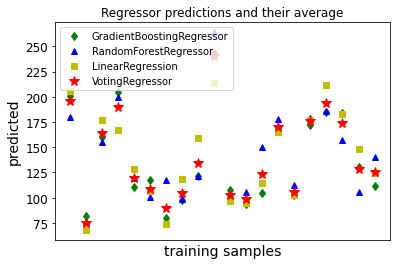

In [17]:
plt.figure()
plt.plot(pred1, 'gd', label='GradientBoostingRegressor')
plt.plot(pred2, 'b^', label='RandomForestRegressor')
plt.plot(pred3, 'ys', label='LinearRegression')
plt.plot(pred4, 'r*', ms=10, label='VotingRegressor')

plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted')
plt.xlabel('training samples')
plt.legend(loc="best")
plt.title('Regressor predictions and their average')

plt.show()

#### Start Pile data !!
# Voting
---

In [18]:
# Reset X and y by Pile data
X = Xp.copy()
y = yp.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [19]:
#from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
#from sklearn.pipeline import make_pipeline
#from sklearn.preprocessing import StandardScaler
# refer to sklearn.svm.SVR : regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))

# Train regressor
reg1 = GradientBoostingRegressor(random_state=1)
reg2 = RandomForestRegressor(random_state=1)
reg3 = LinearRegression()
reg4 = SVR('linear',  epsilon=5000)
reg5 = LinearSVR(random_state=42, tol=1e-5)

reg1.fit(X, y)
reg2.fit(X, y)
reg3.fit(X, y)
reg4.fit(X, y)
reg5.fit(X, y)

ereg = VotingRegressor([('gb', reg1), ('rf', reg2), ('lr', reg3)
                           , ('svr', reg4), ('LinSVR', reg5)])
ereg.fit(X, y)


VotingRegressor(estimators=[('gb',
                             GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                    

Saving figure unscaled predict


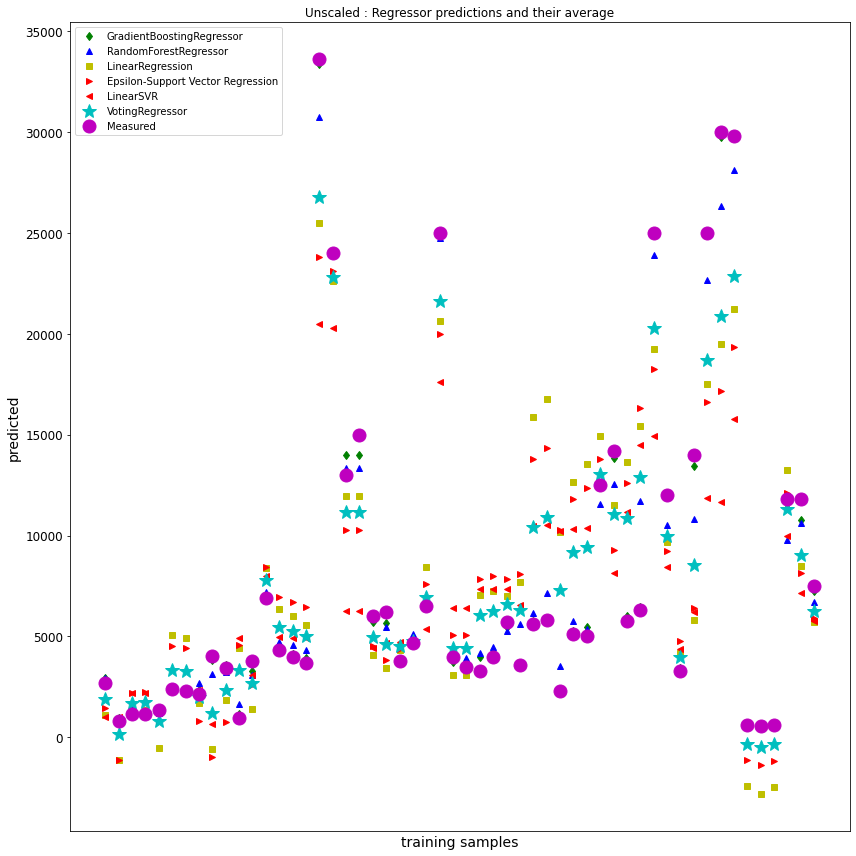

In [20]:
# Making predictions
# Now we will use each of the regressors to make the 20 first predictions.

#xt = X[:20,:]
xt = X[:]
pred1 = reg1.predict(xt)
pred2 = reg2.predict(xt)
pred3 = reg3.predict(xt)
pred4 = reg4.predict(xt)
pred5 = reg5.predict(xt)
pred6 = ereg.predict(xt)

plt.figure(figsize=(12, 12))
plt.plot(pred1, 'gd', label='GradientBoostingRegressor')
plt.plot(pred2, 'b^', label='RandomForestRegressor')
plt.plot(pred3, 'ys', label='LinearRegression')
plt.plot(pred4, 'r>', label='Epsilon-Support Vector Regression')
plt.plot(pred5, 'r<', label='LinearSVR')

plt.plot(pred6, 'c*', ms=15, label='VotingRegressor')

plt.plot(y, 'mo',ms=13,  label='Measured')
# ms = marker size
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted')
plt.xlabel('training samples')
plt.legend(loc=2)
plt.title('Unscaled : Regressor predictions and their average')

save_fig("unscaled predict")

plt.show()


[  6.144  91.212 -24.32  -43.601]
[-6.386]
[ 1022.845  1016.002  2221.044  2222.887  1425.177  2400.457  2392.47
  2355.286   642.315  2309.719  4942.476  3115.696  8013.627  4956.373
  4939.169  4918.279 20469.248 20281.545  6257.669  6257.669]
Saving figure linearSVR, not Scaled


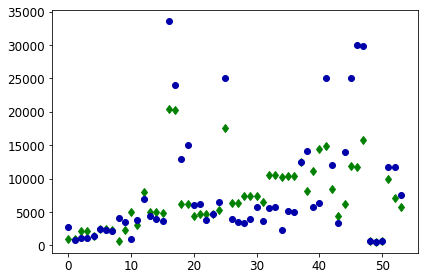

In [21]:
# example LinearSVR
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression
#X, y = make_regression(n_features=4, random_state=0)
#regr = make_pipeline(StandardScaler(),LinearSVR(random_state=42, tol=1e-5))
regr = LinearSVR(random_state=42, tol=1e-5)
regr.fit(X, y)
#print(regr.named_steps['linearsvr'].coef_)
#print(regr.named_steps['linearsvr'].intercept_)
print(regr.coef_)
print(regr.intercept_)
print(regr.predict(X[0:20]))
X_p = regr.predict(X)
#plt.figure(figsize=(3, 3))
plt.plot(X_p, 'gd', y, 'o', label='LinearSVR')
save_fig("linearSVR, not Scaled")
plt.show()

### Processing Data
[6.3. Preprocessing data](https://scikit-learn.org/stable/modules/preprocessing.html)

6.3. Preprocessing data

    6.3.1. Standardization, or mean removal and variance scaling
        1	StandardScaler	기본 스케일. 평균과 표준편차 사용
        2	MinMaxScaler	최대/최소값이 각각 1, 0이 되도록 스케일링
        3	MaxAbsScaler	최대절대값과 0이 각각 1, 0이 되도록 스케일링
        4	RobustScaler	중앙값(median)과 IQR(interquartile range) 사용. 아웃라이어의 영향을 최소화
    6.3.2. Non-linear transformation
    6.3.3. Normalization
    6.3.4. Encoding categorical features
    6.3.5. Discretization
    6.3.6. Imputation of missing values
    6.3.7. Generating polynomial features
    6.3.8. Custom transformers
#### Prepare the data for ML algorithm
* *Data Cleaning*
* *Handling Text and Categorical Attributes*
* *Custom Transformers*
* *Feature Scaling*
* *Transformation Pipelines*

### Scaler
#### Standard Scaler

In [22]:
df.describe().loc[['max','min'],['Len','Dia', 'mean_N','NB']]

,Len,Dia,mean_N,NB
max,92.0,253.0,48.0,66.0
min,9.1,30.5,2.8,4.0


In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
scaler_y = StandardScaler().fit(y.reshape(-1,1))
print(scaler.mean_)
#print(X)

X_scaled = scaler.transform(X)
y_scaled = scaler_y.transform(y.reshape(-1,1))

print(scaler.mean_)

[ 39.226 100.641  20.76   42.343]
[ 39.226 100.641  20.76   42.343]


<AxesSubplot:>

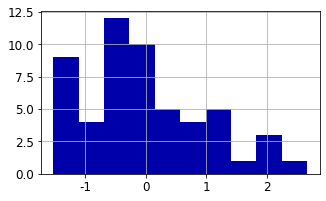

In [24]:
pd.DataFrame(X_scaled).iloc[:,0].hist(bins=10, figsize=(5,3))


<AxesSubplot:>

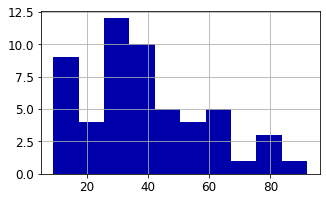

In [25]:
df["Len"].hist(bins=10, figsize=(5,3))


In [26]:
# example *******************************************
from sklearn import preprocessing
X3_train = np.array([[ 1., -1.,  2.],
                    [ 10.,  0.,  0.],
                    [ 0.,  1., -1.]])
scaler3 = preprocessing.StandardScaler().fit(X3_train)
scaler3
print('mean: {}'.format(scaler3.mean_))
print('var : {}'.format(scaler3.var_))
print('scale : {}'.format(scaler3.scale_))
X3_scaled = scaler3.transform(X3_train)
print(X3_scaled)

X3_scaled*scaler3.var_**0.5+scaler3.mean_

mean: [3.667 0.    0.333]
var : [20.222  0.667  1.556]
scale : [4.497 0.816 1.247]
[[-0.593 -1.225  1.336]
 [ 1.408  0.    -0.267]
 [-0.815  1.225 -1.069]]


array([[ 1., -1.,  2.],
       [10.,  0.,  0.],
       [ 0.,  1., -1.]])

([<matplotlib.axis.XTick at 0x1d8e6085820>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

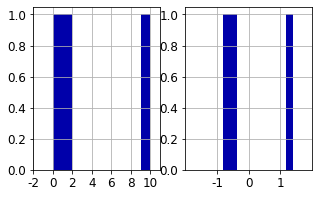

In [27]:
fig, axes = plt.subplots(1,2, figsize=(5,3))

pd.DataFrame(X3_train).iloc[:,0].hist(bins=10, ax=axes[0])

pd.DataFrame(X3_scaled).iloc[:,0].hist(bins=10, ax=axes[1] )

axes[0].set_xlim([-1, 11])
axes[1].set_xlim([-2, 2])

plt.sca(axes[0])
plt.xticks(np.arange(-2, 10+1, 2.0))
plt.sca(axes[1])
plt.xticks(np.arange(-1, 2, 1.0))

# end of example *********************************************

#### Voting for Scaled data

In [28]:
y_0 = y.copy()
X_0 = X.copy()
y = y_scaled.copy()
X = X_scaled.copy()

In [29]:
# scaling both of features and target X, y

#from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
#from sklearn.pipeline import make_pipeline
#from sklearn.preprocessing import StandardScaler
# refer to sklearn.svm.SVR : regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))

# Train regressor
reg1 = GradientBoostingRegressor(random_state=1)
reg2 = RandomForestRegressor(random_state=1)
reg3 = LinearRegression()
reg4 = SVR('linear',  epsilon=0.01)
reg5 = LinearSVR(random_state=42, tol=1e-5)

reg1.fit(X, y)
reg2.fit(X, y)
reg3.fit(X, y)
reg4.fit(X, y)
reg5.fit(X, y)

ereg = VotingRegressor([('gb', reg1), ('rf', reg2), ('lr', reg3), ('svr', reg4),('linSVR',reg5)])
ereg.fit(X, y)


c:\users\user\.conda\envs\venv_01\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-29-021e5a5aeaa6>:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg2.fit(X, y)
c:\users\user\.conda\envs\venv_01\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\user\.conda\envs\venv_01\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = 

VotingRegressor(estimators=[('gb',
                             GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                    

Saving figure scaled predicted


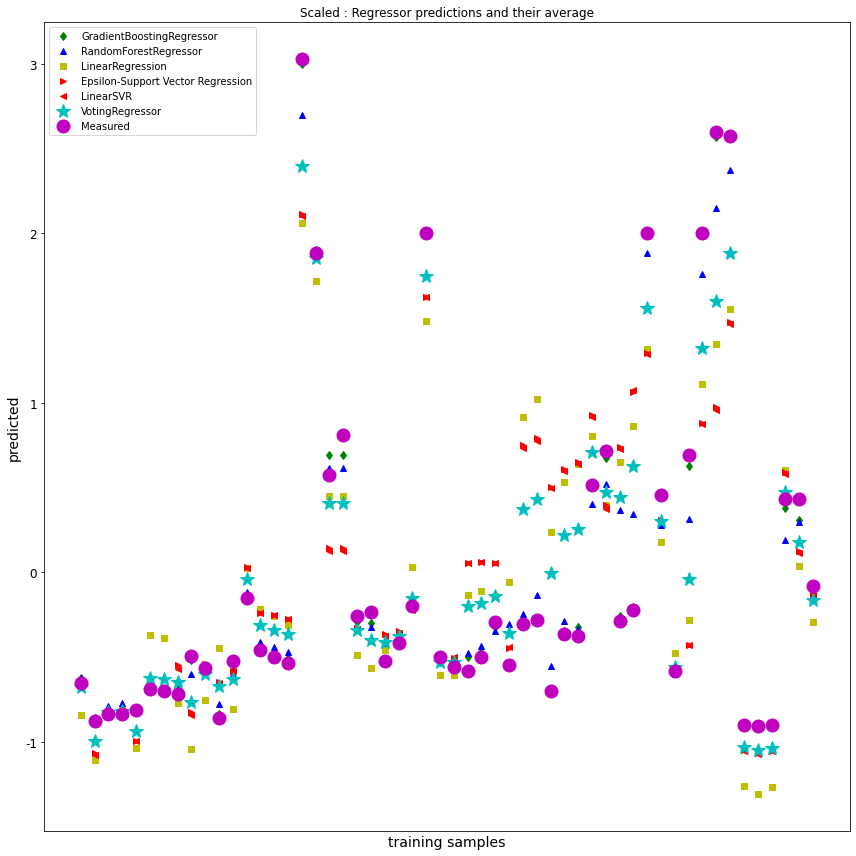

In [30]:
# Making predictions
# Now we will use each of the regressors to make the 20 first predictions.
# Scaled Plot

#xt = X[:20,:]
xt = X[:]
pred1 = reg1.predict(xt)
pred2 = reg2.predict(xt)
pred3 = reg3.predict(xt)
pred4 = reg4.predict(xt)
pred5 = reg5.predict(xt)

pred6 = ereg.predict(xt)

plt.figure(figsize=(12, 12))
plt.plot(pred1, 'gd', label='GradientBoostingRegressor')
plt.plot(pred2, 'b^', label='RandomForestRegressor')
plt.plot(pred3, 'ys', label='LinearRegression')
plt.plot(pred4, 'r>', label='Epsilon-Support Vector Regression')
plt.plot(pred5, 'r<', label='LinearSVR')

plt.plot(pred6, 'c*', ms=15, label='VotingRegressor')

plt.plot(y, 'mo',ms=13,  label='Measured')
# ms = marker size
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted')
plt.xlabel('training samples')
plt.legend(loc=2)
plt.title('Scaled : Regressor predictions and their average')
save_fig('scaled predicted')
plt.show()


Saving figure Trans Unscaled predicted


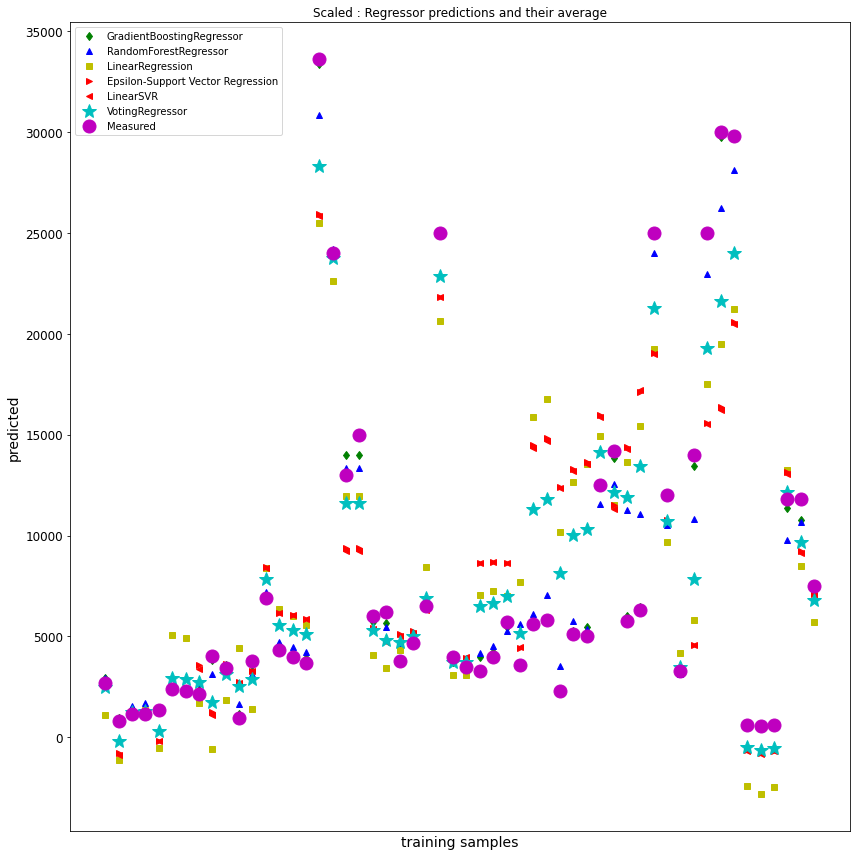

In [31]:
# Making predictions
# Now we will use each of the regressors to make the 20 first predictions.
# Unscaled Plot from the scaled plot

#xt = X[:20,:]
xt = X[:]


pred1 = reg1.predict(xt)
pred2 = reg2.predict(xt)
pred3 = reg3.predict(xt)
pred4 = reg4.predict(xt)
pred5 = reg5.predict(xt)

pred6 = ereg.predict(xt)

pred1 = pred1*scaler_y.var_**0.5+scaler_y.mean_
pred2 = pred2*scaler_y.var_**0.5+scaler_y.mean_
pred3 = pred3*scaler_y.var_**0.5+scaler_y.mean_
pred4 = pred4*scaler_y.var_**0.5+scaler_y.mean_
pred5 = pred5*scaler_y.var_**0.5+scaler_y.mean_
pred6 = pred6*scaler_y.var_**0.5+scaler_y.mean_

plt.figure(figsize=(12, 12))
plt.plot(pred1, 'gd', label='GradientBoostingRegressor')
plt.plot(pred2, 'b^', label='RandomForestRegressor')
plt.plot(pred3, 'ys', label='LinearRegression')
plt.plot(pred4, 'r>', label='Epsilon-Support Vector Regression')
plt.plot(pred5, 'r<', label='LinearSVR')

plt.plot(pred6, 'c*', ms=15, label='VotingRegressor')

y_usc = y*scaler_y.var_**0.5+scaler_y.mean_
plt.plot(y_usc, 'mo',ms=13,  label='Measured')
# ms = marker size
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted')
plt.xlabel('training samples')
plt.legend(loc=2)
plt.title('Scaled : Regressor predictions and their average')
save_fig('Trans Unscaled predicted')
plt.show()





In [32]:
# Check scaled X vs. unscaled y
from sklearn.svm import LinearSVR

# Scaled X vs.y and then transform to unscale - LinearSVR
regr = LinearSVR(random_state=42, tol=1e-5)
regr = regr.fit(X, y)
print('Coefs scaled X, y : {}'.format(regr.coef_))
print('Intcpt scaed X, y : {}'.format(regr.intercept_))
print('Predict for scaled X, y :{}'.format(regr.predict(X[0:10])))
print()
# Scaled X vs. Unscaled y
regr2 = LinearSVR(random_state=42, tol=1e-5)
regr2 = regr2.fit(X, y_0)
print('Coefs scaled X, unscaled y : {}'.format(regr2.coef_))
print('Intcpt scaed X, unscaled y : {}'.format(regr2.intercept_))
print('Predict for scaled X, unscaled y :{}'.format(regr2.predict(X[0:10])))
print()
# Unscaled X vs. Unscaled y
regr3 = LinearSVR(random_state=42, tol=1e-5)
regr3 = regr3.fit(X_0, y_0)
print('Coefs unscaled X, y : {}'.format(regr3.coef_))
print('Intcpt unscaed X, y : {}'.format(regr3.intercept_))
print('Predict for Unscaled X, y :{}'.format(regr3.predict(X_0[:20])))
print()



Coefs scaled X, y : [0.107 0.724 0.017 0.035]
Intcpt scaed X, y : [0.014]
Predict for scaled X, y :[-0.652 -1.08  -0.846 -0.844 -0.995 -0.688 -0.695 -0.57  -0.844 -0.564]

Coefs scaled X, unscaled y : [-0.  0.  0. -0.]
Intcpt scaed X, unscaled y : [54.]
Predict for scaled X, unscaled y :[54. 54. 54. 54. 54. 54. 54. 54. 54. 54.]

Coefs unscaled X, y : [  6.144  91.212 -24.32  -43.601]
Intcpt unscaed X, y : [-6.386]
Predict for Unscaled X, y :[ 1022.845  1016.002  2221.044  2222.887  1425.177  2400.457  2392.47
  2355.286   642.315  2309.719  4942.476  3115.696  8013.627  4956.373
  4939.169  4918.279 20469.248 20281.545  6257.669  6257.669]



c:\users\user\.conda\envs\venv_01\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ 39.226 100.641  20.76   42.343]
[ 392.044 3080.808  110.811  158.572]


Text(0.5, 1.0, 'Unscaled, LinSVR')

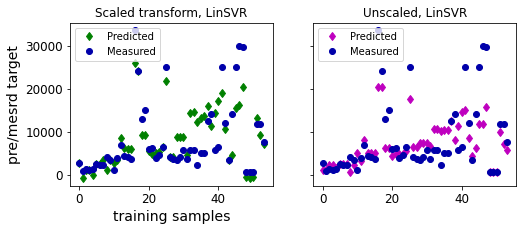

In [33]:
X_p = regr.predict(X)
#plt.figure(figsize=(3, 3))
print(scaler.mean_)
print(scaler.var_)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,3), sharey=True)
#fig.suptitle('Scaled vs. Unscaled', fontsize='16')

ax1.plot(X_p*scaler_y.var_**0.5+scaler_y.mean_, 'gd', label='Predicted')
ax1.plot(y*scaler_y.var_**0.5+scaler_y.mean_, 'o', label='Measured')
ax1.set_ylabel('pre/mesrd target')
ax1.set_xlabel('training samples')
ax1.legend(loc=2)
ax1.set_title('Scaled transform, LinSVR', fontsize='12')

ax2.plot(regr3.predict(X_0), 'md', label='Predicted')
ax2.plot(y_0, 'o', label='Measured')
ax2.legend(loc=2)
ax2.set_title('Unscaled, LinSVR', fontsize='12')



In [34]:
#tree_reg.fit(X_train,y_train)
#regr = regr.fit(X, y)
r1 = regr.score(X, y)
r3 = regr3.score(X, y)
print (" Scaled R^2 : {:.2f}".format(r1))
print (" Unscaled R^2 : {:.2f}".format(r3))

 Scaled R^2 : 0.65
 Unscaled R^2 : -8131.66


In [35]:
print((regr.score(X, y)**0.5*(scaler_y.var_**0.5+scaler_y.mean_))**2)
print(regr.score(X, y)*(scaler_y.var_**0.5+scaler_y.mean_)**2)

[1.791e+08]
[1.791e+08]


In [36]:
# *******************************************************************

column_names = ['Len', 'Dia', 'mean_N', 'NB']
feature_names = np.array([column_names])
feature_names = feature_names.reshape(-1, 1)
coefs = pd.DataFrame(np.array([regr.coef_,regr3.coef_]).T,
    columns=['Unsacaled Coefficients','Scaled Coefficients'], index=feature_names
)
coefs

,Unsacaled Coefficients,Scaled Coefficients
"(Len,)",0.11,6.14
"(Dia,)",0.72,91.21
"(mean_N,)",0.02,-24.32
"(NB,)",0.04,-43.60


([<matplotlib.axis.XTick at 0x1d8e6717f10>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

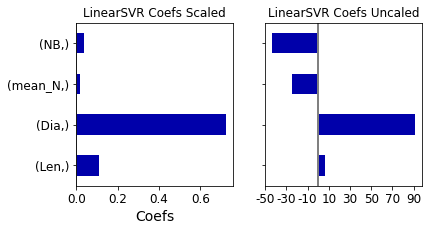

In [37]:
#coefs.iloc[:,0].plot(kind='barh', figsize=(5, 3))
fig, axes = plt.subplots(1,2, figsize=(8,3), sharey=True)

coefs.iloc[:,0].plot(kind='barh', ax=axes[0])
plt.sca(axes[0])
plt.title('LinearSVR Coefs Scaled')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)
axes[0].set_xlabel('Coefs')
#plt.xlim(-5,5)
coefs.iloc[:,1].plot(kind='barh', ax=axes[1])
plt.sca(axes[1])
plt.title('LinearSVR Coefs Uncaled')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

plt.sca(axes[1])
plt.xticks(np.arange(-50, 100, 20.0))

<AxesSubplot:>

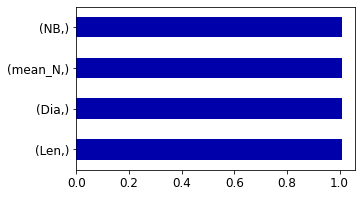

In [38]:
X_df = pd.DataFrame(X, columns=feature_names)
X_df.std(axis=0).plot(kind='barh', figsize=(5, 3))

In [39]:
(regr.coef_*np.array(X_df.std(axis=0))).T

array([0.108, 0.73 , 0.017, 0.035])

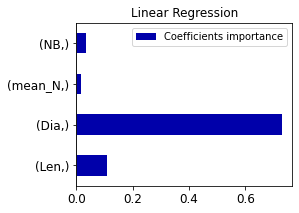

In [40]:
coefs2 = pd.DataFrame(
    (regr.coef_*np.array(X_df.std(axis=0))).T,
    columns=['Coefficients importance'], index=feature_names
)
coefs2.plot(kind='barh', figsize=(5, 3))
plt.title('Linear Regression')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)





In [41]:
###############################################################################################

# Bagging ensembles

In [42]:
X = X_0.copy()
y = y_0.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [43]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

bag_reg = BaggingRegressor(
    DecisionTreeRegressor(random_state=42),
    max_samples=10, bootstrap=True, random_state=42)
#DecisionTreeRegressor(random_state=42), n_estimators=500,
#    max_samples=100, bootstrap=True, random_state=42)
bag_reg.fit(X, y)
y_pred_bag = bag_reg.predict(X)

In [44]:
from sklearn.metrics import accuracy_score
#print(accuracy_score(y, y_pred))

r = bag_reg.score(X, y)
print (" Scaled R^2 : {:.2f}".format(r))

# the coefficient of determination R^2 of the prediction.


 Scaled R^2 : 0.67


In [45]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X, y)
y_pred_tree = tree_reg.predict(X)
print(tree_reg.score(X, y))
y_pred_tree - y

# Overfitting !!!!

0.9994424400445512


array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,  1000., -1000.,     0.,     0.,     0.,     0.,
           0.,     0.,  -250.,   250.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.])

In [46]:
np.sum(y == y_pred_tree)/len(y_pred_tree)
#np.sum(y_pred == y)/len(y_pred_tree)

0.9259259259259259

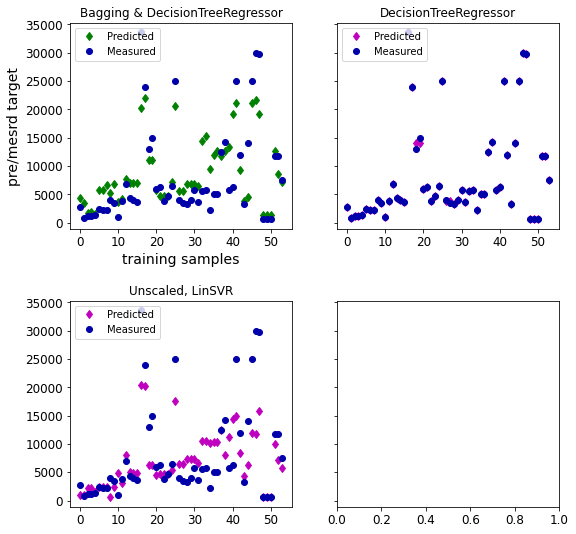

In [47]:
fix, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(8,8), sharey='all')
#fig.suptitle('Scaled vs. Unscaled', fontsize='16')

ax1.plot(y_pred_bag, 'gd', label='Predicted')
ax1.plot(y, 'o', label='Measured')
ax1.set_ylabel('pre/mesrd target')
ax1.set_xlabel('training samples')
ax1.legend(loc=2)
ax1.set_title('Bagging & DecisionTreeRegressor', fontsize='12')

ax2.plot(y_pred_tree, 'md', label='Predicted')
ax2.plot(y, 'o', label='Measured')
ax2.legend(loc=2)
ax2.set_title('DecisionTreeRegressor', fontsize='12')

ax3.plot(regr3.predict(X_0), 'md', label='Predicted')
ax3.plot(y_0, 'o', label='Measured')
ax3.legend(loc=2)
ax3.set_title('Unscaled, LinSVR', fontsize='12')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35,
                    wspace=0.2)


In [48]:
### bagging 과 cross validation 차이점은 ?

# Random Forests
- a Random Forest is an ensemble of Decision Trees, generally trained via the bagging method (or sometimes pasting), typically with max_samples
set to the size of the training set

In [49]:
from sklearn.ensemble import RandomForestRegressor

rnd_reg = RandomForestRegressor(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_reg.fit(X_train, y_train)
y_pred_rf = rnd_reg.predict(X_test)

print(rnd_reg.score(X_train, y_train))

print(rnd_reg.score(X_test, y_test))

0.94564423937617
0.715347992373885


In [50]:
bag_reg = BaggingRegressor(
    DecisionTreeRegressor(max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, random_state=42)
#DecisionTreeRegressor(random_state=42), n_estimators=500,
#    max_samples=100, bootstrap=True, random_state=42)
bag_reg.fit(X_train, y_train)
y_pred = bag_reg.predict(X_test)

print(bag_reg.score(X_train, y_train))
print(bag_reg.score(X_test, y_test))

0.9454543477889661
0.7097269878849481


In [51]:
print(np.sum(y_pred == y_pred_rf) / len(y_pred) ) # almost identical predictions
print(np.sum(y_pred == y_pred_rf)  ) # almost identical predictions
print(np.sum(abs(y_pred - y_pred_rf) < 200)/len(y_pred))

0.0
0
0.8571428571428571


In [52]:
for name, score in zip(feature_names, rnd_reg.feature_importances_):
    print(name, score)

['Len'] 0.3093305176019982
['Dia'] 0.6379411351354367
['mean_N'] 0.04910759174642925
['NB'] 0.0036207555161359055


In [53]:
rnd_reg.feature_importances_



array([0.309, 0.638, 0.049, 0.004])

## Out-of-Bag evaluation

In [54]:
bag_reg = BaggingRegressor(
    DecisionTreeRegressor(max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True,oob_score=True, random_state=42)

bag_reg.fit(X_train, y_train)
print(bag_reg.score(X_test, y_test))

bag_reg.oob_score_

0.7097269878849481


0.6217481437946644

In [55]:
#bag_clf.oob_decision_function_
bag_reg.oob_prediction_




array([ 6615.263,  1295.764,  9062.539,  9974.079, 18733.717, 18573.   ,
        1928.579,  4992.834,  3468.259, 21199.057,  4541.684,  6432.56 ,
       14722.457,  2402.053,  2839.271, 24114.948,  4761.74 ,  6475.426,
       17641.437,  4724.87 , 16618.901,  1670.87 ,  3942.432,  2715.023,
       20572.597, 18605.474,  6274.444,  5586.253,  2500.752,  3540.472,
        5513.17 , 11791.939,  5216.208,  5274.577,  4200.095,  5771.354,
        4995.143,  5587.739,  5831.32 ,  8053.913])

# AdaBoost

In [56]:
from sklearn.ensemble import AdaBoostRegressor

ada_reg = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=10), n_estimators=200,
     learning_rate=0.5, random_state=42)
ada_reg.fit(X_train, y_train)

print(ada_reg.score(X_train, y_train))
print(bag_reg.score(X_test, y_test))

y_pred_ada = ada_reg.predict(X)

0.9988645255264719
0.7097269878849481


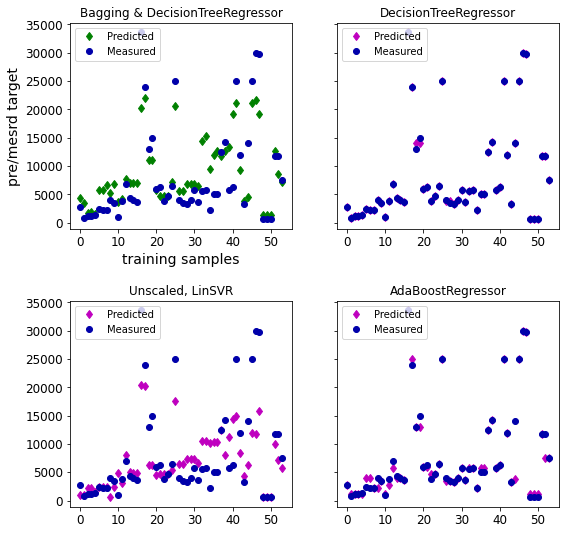

In [57]:
fix, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(8,8), sharey='all')
#fig.suptitle('Scaled vs. Unscaled', fontsize='16')

ax1.plot(y_pred_bag, 'gd', label='Predicted')
ax1.plot(y, 'o', label='Measured')
ax1.set_ylabel('pre/mesrd target')
ax1.set_xlabel('training samples')
ax1.legend(loc=2)
ax1.set_title('Bagging & DecisionTreeRegressor', fontsize='12')

ax2.plot(y_pred_tree, 'md', label='Predicted')
ax2.plot(y, 'o', label='Measured')
ax2.legend(loc=2)
ax2.set_title('DecisionTreeRegressor', fontsize='12')

ax3.plot(regr3.predict(X_0), 'md', label='Predicted')
ax3.plot(y_0, 'o', label='Measured')
ax3.legend(loc=2)
ax3.set_title('Unscaled, LinSVR', fontsize='12')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35,
                    wspace=0.2)

ax4.plot(y_pred_ada, 'md', label='Predicted')
ax4.plot(y_0, 'o', label='Measured')
ax4.legend(loc=2)
ax4.set_title('AdaBoostRegressor', fontsize='12')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35,
                    wspace=0.2)


# Gradient Boosting
### Gradient Tree Boosting, or Gradient Boosted Regression Trees (GBRT).

In [58]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [59]:
X = X_0.copy()
y = y_0.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [60]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=3, random_state=42)
tree_reg1.fit(X, y)


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

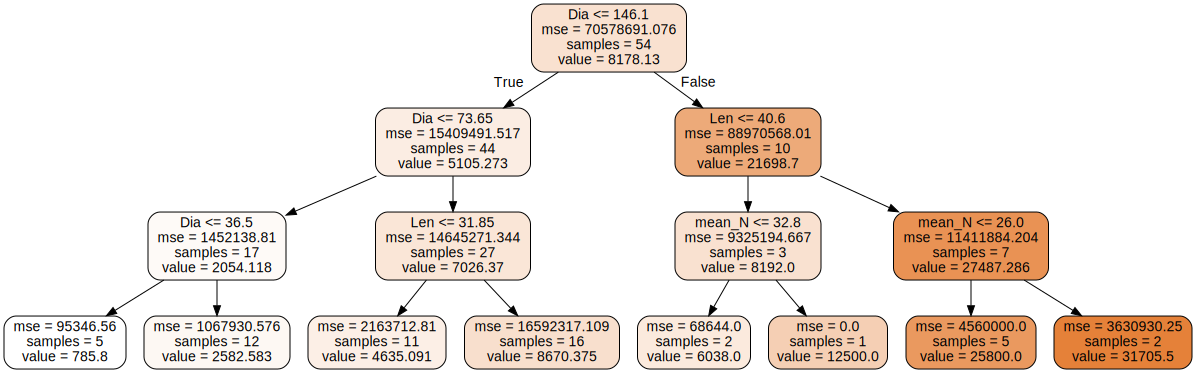

In [61]:
import graphviz
from graphviz import Source
from sklearn.tree import export_graphviz

export_graphviz(
        tree_reg1,
#        out_file=os.path.join(IMAGES_PATH, "regression_tree.dot"),
        out_file="regression_tree.dot",
        feature_names=["Len", 'Dia', 'mean_N', "NB" ],
        rounded=True,
        filled=True)

with open("regression_tree.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))




In [62]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

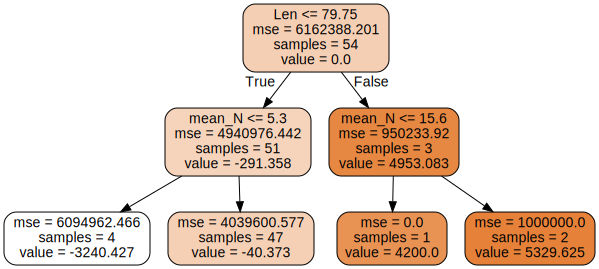

In [63]:
export_graphviz(
        tree_reg2,
#        out_file=os.path.join(IMAGES_PATH, "regression_tree.dot"),
        out_file="regression_tree.dot",
        feature_names=["Len", 'Dia', 'mean_N', "NB" ],
        rounded=True,
        filled=True)

with open("regression_tree.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))



In [64]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [65]:
y_pred = sum(tree.predict(X_train) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [66]:
y_pred

array([ 1531.773,   941.187, 12075.963,  8825.762, 25375.963,  5567.057,
         941.187,  5625.708,  2737.97 , 31281.463,  4790.478,  5567.057,
       25375.963,  2737.97 ,  2737.97 , 31281.463,  4790.478,  -462.083,
        5613.963,  4790.478, 29616.336,   941.187,  4790.478,  2737.97 ,
       25375.963,  5613.963,  5567.057,  4790.478,  2737.97 ,  2737.97 ,
        4790.478, 14195.76 ,  4790.478,  4790.478,  2737.97 , 12664.667,
        5625.708,  4790.478, 12664.667, 12664.667])

In [67]:
df.describe().loc[['max','min'],['Qu','Len','Dia', 'mean_N','NB']]


























,Qu,Len,Dia,mean_N,NB
max,33611.0,92.0,253.0,48.0,66.0
min,550.0,9.1,30.5,2.8,4.0


In [68]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

ValueError: Number of features of the model must match the input. Model n_features is 4 and input n_features is 1 

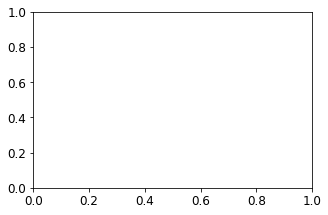

In [69]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

In [73]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [74]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Saving figure gbrt


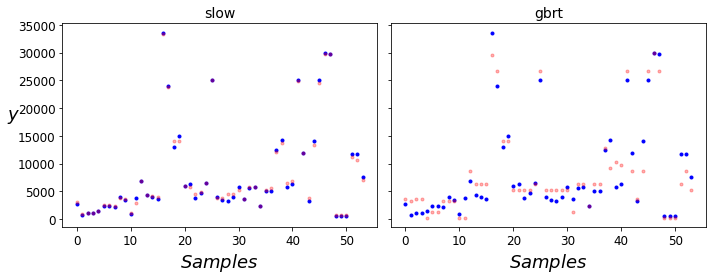

In [75]:
#def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
def plot_regression_predictions(plt_reg, X, y,  ylabel="$y$"):
#    xs = np.linspace(axes[0], axes[1], 100).reshape(-1, 1)
#    x1 = np.full((100,1), 100) #dia = 100
#    x2 = np.full((100,1), 30) #mean_N = 30
#    x3 = np.full((100,1), 30) #NB = 30
    y_pred = plt_reg.predict(X)
#    plt.axis(axes)
    plt.xlabel("$Samples$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(y, "b.")
    plt.plot(y_pred, "r.", alpha=0.3, linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(gbrt_slow, X, y)
plt.title("slow", fontsize=14)

plt.sca(axes[1])
plot_regression_predictions(gbrt, X, y, ylabel=None)
plt.title("gbrt", fontsize=14)

save_fig("gbrt")


ValueError: Number of features of the model must match the input. Model n_features is 4 and input n_features is 1 

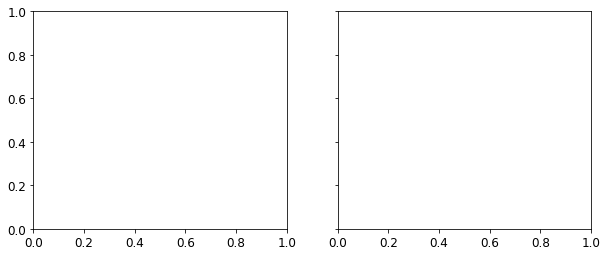

In [76]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

save_fig("gbrt_learning_rate_plot")
plt.show()

## Gradient Boosting with Early stopping

In [77]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=38,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [78]:
min_error = np.min(errors)

Saving figure early_stopping_gbrt_plot


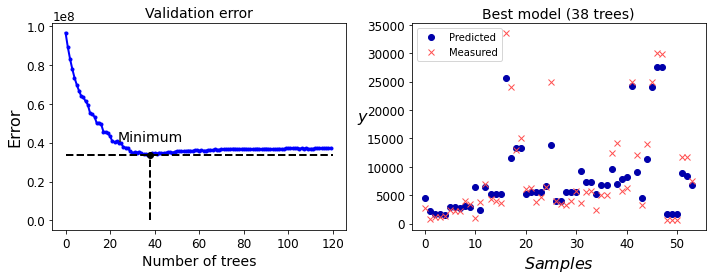

In [79]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
#plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
#plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.plot(gbrt_best.predict(X),  'o',label='Predicted')
plt.plot(y, 'x',label='Measured')
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$Samples$", fontsize=16)
plt.legend(loc=2)

save_fig("early_stopping_gbrt_plot")
plt.show()

In [80]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [81]:
print(gbrt.n_estimators)

43


In [82]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 33783724.90538169


## Using XGBoost

In [83]:
try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None

In [84]:
if xgboost is not None:  # not shown in the book
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_test)
    val_error = mean_squared_error(y_test, y_pred) # Not shown
    print("Validation MSE:", val_error)           # Not shown

Validation MSE: 15126028.304341001


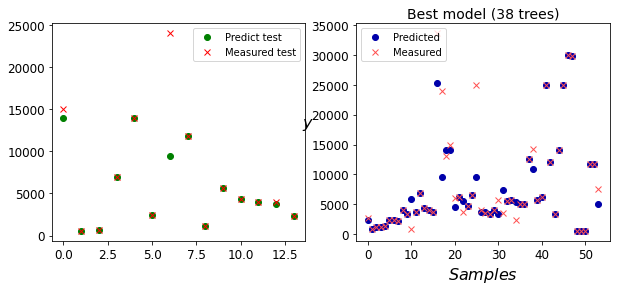

In [95]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
#plt.scatter(X_val, y_pred, color="none", edgecolor="green")
plt.plot(y_pred, 'go' ,label='Predict test')
plt.plot(y_test, 'rx', alpha = 1.0, label='Measured test')
plt.legend(loc="upper right")

plt.subplot(122)
plt.plot(xgb_reg.predict(X),  'o',label='Predicted')
plt.plot(y, 'x',label='Measured')
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$Samples$", fontsize=16)
plt.legend(loc=2)

In [97]:
if xgboost is not None:  # not shown in the book
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_test, y_test)], early_stopping_rounds=2)
    y_pred = xgb_reg.predict(X_test)
    val_error = mean_squared_error(y_test, y_pred)  # Not shown
    print("Validation MSE:", val_error)            # Not shown

[0]	validation_0-rmse:8026.36914
[1]	validation_0-rmse:6970.98291
[2]	validation_0-rmse:6226.13818
[3]	validation_0-rmse:5824.49805
[4]	validation_0-rmse:5544.56592
[5]	validation_0-rmse:5033.43994
[6]	validation_0-rmse:4745.71533
[7]	validation_0-rmse:4521.24756
[8]	validation_0-rmse:4348.01562
[9]	validation_0-rmse:4208.91309
[10]	validation_0-rmse:4110.97168
[11]	validation_0-rmse:4027.21436
[12]	validation_0-rmse:3997.71118
[13]	validation_0-rmse:3975.00391
[14]	validation_0-rmse:3957.68262
[15]	validation_0-rmse:3944.37598
[16]	validation_0-rmse:3931.65112
[17]	validation_0-rmse:3922.00732
[18]	validation_0-rmse:3897.26294
[19]	validation_0-rmse:3893.57617
[20]	validation_0-rmse:3899.22144
Validation MSE: 15159936.514608217


In [98]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

66 ms ± 1.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [99]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

15.7 ms ± 120 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Exercise solutions

## 1. to 7.

See Appendix A.

## 8. Voting Classifier

Exercise: _Load the MNIST data and split it into a training set, a validation set, and a test set (e.g., use 50,000 instances for training, 10,000 for validation, and 10,000 for testing)._

The MNIST dataset was loaded earlier.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    mnist.data, mnist.target, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)

Exercise: _Then train various classifiers, such as a Random Forest classifier, an Extra-Trees classifier, and an SVM._

In [ ]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

In [ ]:
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_clf = LinearSVC(random_state=42)
mlp_clf = MLPClassifier(random_state=42)

In [ ]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

In [ ]:
[estimator.score(X_val, y_val) for estimator in estimators]

The linear SVM is far outperformed by the other classifiers. However, let's keep it for now since it may improve the voting classifier's performance.

Exercise: _Next, try to combine them into an ensemble that outperforms them all on the validation set, using a soft or hard voting classifier._

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf),
]

In [ ]:
voting_clf = VotingClassifier(named_estimators)

In [ ]:
voting_clf.fit(X_train, y_train)

In [ ]:
voting_clf.score(X_val, y_val)

In [ ]:
[estimator.score(X_val, y_val) for estimator in voting_clf.estimators_]

Let's remove the SVM to see if performance improves. It is possible to remove an estimator by setting it to `None` using `set_params()` like this:

In [ ]:
voting_clf.set_params(svm_clf=None)

This updated the list of estimators:

In [ ]:
voting_clf.estimators

However, it did not update the list of _trained_ estimators:

In [ ]:
voting_clf.estimators_

So we can either fit the `VotingClassifier` again, or just remove the SVM from the list of trained estimators:

In [ ]:
del voting_clf.estimators_[2]

Now let's evaluate the `VotingClassifier` again:

In [ ]:
voting_clf.score(X_val, y_val)

A bit better! The SVM was hurting performance. Now let's try using a soft voting classifier. We do not actually need to retrain the classifier, we can just set `voting` to `"soft"`:

In [ ]:
voting_clf.voting = "soft"

In [ ]:
voting_clf.score(X_val, y_val)

Nope, hard voting wins in this case.

_Once you have found one, try it on the test set. How much better does it perform compared to the individual classifiers?_

In [ ]:
voting_clf.voting = "hard"
voting_clf.score(X_test, y_test)

In [ ]:
[estimator.score(X_test, y_test) for estimator in voting_clf.estimators_]

The voting classifier only very slightly reduced the error rate of the best model in this case.

## 9. Stacking Ensemble

Exercise: _Run the individual classifiers from the previous exercise to make predictions on the validation set, and create a new training set with the resulting predictions: each training instance is a vector containing the set of predictions from all your classifiers for an image, and the target is the image's class. Train a classifier on this new training set._

In [ ]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

In [ ]:
X_val_predictions

In [ ]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_val_predictions, y_val)

In [ ]:
rnd_forest_blender.oob_score_

You could fine-tune this blender or try other types of blenders (e.g., an `MLPClassifier`), then select the best one using cross-validation, as always.

Exercise: _Congratulations, you have just trained a blender, and together with the classifiers they form a stacking ensemble! Now let's evaluate the ensemble on the test set. For each image in the test set, make predictions with all your classifiers, then feed the predictions to the blender to get the ensemble's predictions. How does it compare to the voting classifier you trained earlier?_

In [ ]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [ ]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y_test, y_pred)

This stacking ensemble does not perform as well as the voting classifier we trained earlier, it's not quite as good as the best individual classifier.